In [15]:
# system library
import os
import sys
import json

# useful libraries
import math
import operator
import itertools
import statistics
import collections
from collections import Counter
from collections import OrderedDict

# pandas
import pandas as pd

# numpy
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# visualisarion
import pydotplus
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Image

# sklearn
import sklearn
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# dimensional reducers
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  # classification
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression  # regression

# scalers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder

# performance visualisation 
from sklearn import tree
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_decision_regions
from yellowbrick.model_selection import LearningCurve
from sklearn.metrics import auc, roc_curve, roc_auc_score 

# tree classifiers
from sklearn.tree import DecisionTreeClassifier

# linear classifiers
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# neighbors classifiers
from sklearn.neighbors import KNeighborsClassifier

# naive_bayes classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# ensemble classifiers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

# svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# nn
from sklearn.neural_network import MLPClassifier

plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

from yellowbrick.style import set_palette
set_palette('bold')

### Global parameters

In [16]:
n_iter = 10
scoring = 'f1_weighted'
random_state = 42

# test_n_splits = 9
test_n_splits = 3

model = MLPClassifier(random_state=random_state)
model_name = "MLPClassifier"

learning_curve_flag = False
v_or_t_flag = "TST"
cmap = plt.cm.Greys
color = "grey"

hidden_layer_sizes = (100, 200,100)

## Caricamento dataset

In [17]:
train = pd.read_csv('../data/reduced_cleaned_files/train_reduced_cleaned_4.csv')
X_train = train.drop(['Activity'], axis=1)
y_train = train['Activity']
y_train = pd.DataFrame(y_train)

print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))

X_train and y_train : ((7261, 200),(7261, 1))


In [18]:
X_test = pd.read_csv('../data/reduced_files/X_test_reduced_UFS.csv')
y_test = pd.read_csv('../data/csv_files/y_test.csv')
#X_train = train.drop(['subject', 'Activity','ActivityName'], axis=1)

#y_train = train['Activity']
#y_train = pd.DataFrame(y_train)
print('X_test and y_test : ({},{})'.format(X_test.shape, y_test.shape))

X_test and y_test : ((2947, 200),(2947, 1))


In [19]:
X_tr = X_train.copy()
y_tr = y_train.copy()
X_ts = X_test.copy()
y_ts = y_test.copy()

print(X_tr.shape, X_ts.shape)
print(y_tr.shape, y_ts.shape)

(7261, 200) (2947, 200)
(7261, 1) (2947, 1)


# MLPClassifier (baseline classifier)

In [20]:
def model_baseline_classification(X_tr, y_tr, X_ts, y_ts):
    fitted_model = model.fit(X_tr, y_tr.values.ravel())
    y_pred = model.predict(X_ts)
    
    print(confusion_matrix(y_ts, y_pred))
    print(classification_report(y_ts, y_pred))
    
    try:
        features_importance = sorted(zip(X_tr.columns, fitted_model.feature_importances_),reverse=True)
        # print(features_importance)
    except:
        pass
    
    try:
        features_importance = sorted(zip(X_tr.columns, fitted_model.coef_),reverse=True)
        # print(features_importance)
    except:
        pass

In [21]:
model_baseline_classification(X_train, 
                              y_train, 
                              X_test, 
                              y_test)

[[477  18   1   0   0   0]
 [ 45 420   6   0   0   0]
 [  4  11 405   0   0   0]
 [  0   4   0 422  65   0]
 [  0   0   0  31 501   0]
 [  0   0   1   0   0 536]]
              precision    recall  f1-score   support

           1       0.91      0.96      0.93       496
           2       0.93      0.89      0.91       471
           3       0.98      0.96      0.97       420
           4       0.93      0.86      0.89       491
           5       0.89      0.94      0.91       532
           6       1.00      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



# Tuned MLPClassifier

- alpha = Strength of the L2 regularization term

- learning_rate{‘constant’, ‘invscaling’, ‘adaptive’}, default=’constant’

- tol = Tolerance for the optimization.

- early_stopping = Whether to use early stopping to terminate training when validation score is not improving.

- UTILIZZATO ANCHE activation e n units per hidden layer

In [22]:
def get_first_layer(X_tr):
    n_features = X_tr.shape[1]
    layers = []
    for i in range(1, (n_features + 1)):
        layer = (i, )
        layers.append(layer)
    return layers

In [23]:
def get_second_layer(X_tr):
    n_features = X_tr.shape[1]
    layers = []
    for i in range(1, (n_features + 1)):
        for j in range(1, (n_features + 1)):
            layer = (i, j)
            layers.append(layer)
    return layers

In [24]:
def model_grid(X_tr):
    grid = dict()
    n_features = X_tr.shape[1]
    grid['model__hidden_layer_sizes'] = get_first_layer(X_tr) + get_second_layer(X_tr)
    grid['model__activation'] = ['identity', 'logistic', 'tanh', 'relu']
    grid['model__learning_rate'] = ['constant', 'invscaling', 'adaptive']    
    #grid['model__solver'] = ['lbfgs', 'sgd', 'adam']
    grid['model__alpha'] = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
    grid['model__tol'] = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
    grid['model__momentum'] =  list(np.arange(0.1, 1.1, 0.1))
    grid['model__early_stopping'] = [False, True]
    return grid

In [25]:
# PLOT FUNCTIONS
def plot_roc_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_roc(y_ts, y_prob)
    plt.title("%s\'s %s ROC curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_precision_recall_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_precision_recall(y_ts, y_prob)
    plt.title("%s\'s %s Precision-Recall curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_cumulative_gain_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_cumulative_gain(y_ts, y_prob)
    plt.title("%s\'s %s Cumulative Gains curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_lift_curve_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_lift_curve(y_ts, y_prob)
    plt.title("%s\'s %s Lift curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_confusion_matrix(cm, classes, normalize):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("%s\'s %s classification report" % (model_name, v_or_t_flag.upper()))
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_classification_report(y_ts, y_pred):
    model_report = classification_report(y_ts, 
                                       y_pred,
                                       # target_names=['Studio Recording', 'Live Recording'],
                                       output_dict=True)
    model_r = pd.DataFrame(model_report).iloc[:-1, :].T
    sns.heatmap(model_r, annot=True, cmap=cmap, cbar=False)
    plt.title("%s\'s %s confusion matrix" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_decision_boundary(X_tr, y_tr, scaler, model):
    try:
        pca = PCA(n_components=2)
        best_visualisation_scaler = StandardScaler()
        scaled_X_tr = best_visualisation_scaler.fit_transform(X_tr)
        X = pca.fit_transform(scaled_X_tr)
        # X = pca.fit_transform(X_tr)
        y = y_tr.values.ravel()

        model.fit(X, y)
        plt.figure(figsize=(8, 5))
        fig = plot_decision_regions(X=X, y=y, clf=model, legend=2)
        plt.xlabel("PCA component 1")
        plt.ylabel("PCA component 2")
        plt.title("%s's %s decision boundary" % (model_name, v_or_t_flag))
        plt.legend(loc='best')
        plt.grid(False)
        plt.show()
    except ValueError:
        return

def spot_errors(test_label, test_pred):  
    spot_errors = []
    label_errors = []
    for i in range(len(test_label)):
        if test_label[i] != test_pred[i]:
            spot_errors.append('darkred')
            label_errors.append("wrong prediction")
        else:
            spot_errors.append('darkgray')
            label_errors.append("correct prediction")
    return spot_errors, label_errors

def classification_visualizer(test_set, test_label, test_pred):
    test_label = test_label.values
    
    f, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,8))
    errors, label_errors = spot_errors(test_label, test_pred)
    labels = [test_label, test_pred, errors]
    titles = ['True Labels', 'Predicted Labels', 'Misclassifications']
    
    for i in range(0, 3):
        axs[i].scatter(test_set[missclassif_column_name1], test_set[missclassif_column_name2], c=labels[i], cmap='cividis')
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(missclassif_column_name1, fontdict={'fontsize': 'large'})
        axs[i].set_ylabel(missclassif_column_name2, fontdict={'fontsize': 'large'})
        
    plt.suptitle('Visualization of the ' + model_name + ' classifier on the %s' % v_or_t_flag)
    plt.show()
    

def error_visualizer(test_set, test_label, test_pred, column_name1, column_name2):
    test_label = test_label.values
    errors, label_errors = spot_errors(test_label, test_pred)
    
    palette = ['darkgray', 'darkred']
    if errors[0] == 'darkred':
        palette = ['darkred', 'darkgray']
    
    fig = plt.figure(figsize=(5, 6))
    sns.scatterplot(x=test_set[column_name1], y=test_set[column_name2], hue=label_errors, palette=palette)
    plt.title('%s\'s %s misclassifications' % (model_name, v_or_t_flag))
    plt.xlabel(column_name1)
    plt.ylabel(column_name2)

    plt.legend()
    plt.show()
    
def plot_learning_curve(X_tr, y_tr, model, v_or_t_flag):
    second_score = ""
    if v_or_t_flag == 'VAL':
        cv = StratifiedKFold(n_splits=validation_n_splits)
        second_score = "Validation score"
    else:
        cv = StratifiedKFold(n_splits=test_n_splits)
        second_score = "Test score"
    sizes = np.linspace(0.3, 1.0, 10)
    plt.figure(figsize=(8, 5))
    visualizer = LearningCurve(model, cv=cv, scoring=scoring, train_sizes=sizes, 
                                                                       n_jobs=-1, random_state=random_state)

    visualizer.fit(X_tr, y_tr.values.ravel())    
    # visualizer.ax.get_lines()[1].set_label(second_score)
    visualizer.show() 

In [26]:
def get_tuned_model(X_tr, y_tr, params):
    
    X_tr_curr = X_tr.copy()
    
    model_params = list(model_grid(X_tr_curr).keys())
    try:
        n_bins = params['preprocessor__numeric__discretizer__n_bins'] 
        strategy = params['preprocessor__numeric__discretizer__strategy']
        encode = params['preprocessor__numeric__discretizer__encode']
        discretizer = KBinsDiscretizer(encode=encode, n_bins=n_bins, strategy=strategy)
        # scale data
        X_tr_curr = discretizer.fit_transform(X_tr_curr.values)
    except KeyError:
        pass

    try:
        scaler = params['preprocessor__numeric__discretizer__scaler']
        # scale data
        X_tr_curr = scaler.fit_transform(X_tr_curr.values)
    except KeyError:
        pass
    
    # retrieve best hyperameters
    tmp_model_hyperparameters = dict((k, params[k]) for k in model_params if k in params)
    model_hyperparameters = {}
    for key, value in tmp_model_hyperparameters.items():
        key = key.split('model__')[1].replace("'", "")
        model_hyperparameters[key] = value
        
    tuned_model =  model.set_params(**model_hyperparameters)
    tuned_model.fit(X_tr_curr, y_tr.values.ravel())
    
    plot_decision_boundary(X_tr_curr, y_tr, MinMaxScaler(), tuned_model)  # passing random scaler
    
    if learning_curve_flag:
        plot_learning_curve(X_tr_curr, y_tr, tuned_model, v_or_t_flag)
    
    return tuned_model

In [27]:
def grid_search(X_tr, y_tr, X_ts, y_ts, numeric_features, categorical_features, discretizer_flag, 
                                                            scaler_flag, feature_filter_key, feature_flag):
    
    # define the evaluation method
    cv = StratifiedKFold(n_splits=test_n_splits)

    # construct the pipeline to evaluate
    # scaler = RobustScaler()
    grid=model_grid(X_tr)
    steps = [('model', model)]
        
    if feature_filter_key == 'anova':
        anova = SelectKBest(score_func=f_classif)
        steps.insert(0, ('anova', anova))
        grid['anova__k'] = [i+1 for i in range(X_tr.shape[1])]
    elif feature_filter_key == 'rfe':
        rfe = RFE(estimator=DecisionTreeClassifier())
        steps.insert(0, ('rfe', rfe))
        grid['rfe__estimator'] = [DecisionTreeClassifier(), LogisticRegression(max_iter=10000)]
        grid['rfe__n_features_to_select'] = [i+1 for i in range(X_tr.shape[1])]
    
    # construct feature type's column transformer
    numeric_steps = []
    if scaler_flag:      # continous variable normalisation/standardisation
        numeric_steps.insert(0, ('scaler', None))
        grid['preprocessor__numeric__scaler'] = [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler()]
                      
    if discretizer_flag:  # continous variable binning
        numeric_steps.insert(0, ('discretizer', KBinsDiscretizer(encode='ordinal')))  # ordinal bins
        grid['preprocessor__numeric__discretizer__n_bins'] = list(range(2, 11))
        grid['preprocessor__numeric__discretizer__strategy'] = ['uniform', 'quantile', 'kmeans']
        
    numeric_transformer = None
    if len(numeric_steps) > 0:
        numeric_transformer = Pipeline(steps=numeric_steps)
        preprocessor = ColumnTransformer(
        transformers=[('numeric', numeric_transformer, numeric_features)])
        # add numeric ColumnTransformer to global Pipeline
        steps.insert(0, ('preprocessor', preprocessor))
        
    # define the pipeline to evaluate
    pipeline = Pipeline(steps=steps)
    
    # define the grid search
    # search = GridSearchCV(pipeline, grid, scoring='f1_weighted', n_jobs=-1, cv=cv, verbose=2)
    search = RandomizedSearchCV(pipeline, grid, scoring=scoring, n_jobs=-1, 
                                n_iter=n_iter, cv=cv, verbose=2, refit=scoring, random_state=random_state)
    
    # perform the search
    results = search.fit(X_tr, y_tr.values.ravel())
    
    # summarize best
    score = results.best_score_
    params = results.best_params_
    print('Best Mean F1_weighted: %.3f ' % score)
    print('Best Config: %s ' % params)
    
    # perform classification (linear model doesn't predict an integer value => no predict_proba)
    y_pred = search.predict(X_ts)
    y_prob_flag = True
    try:
        y_prob = search.predict_proba(X_ts)
    except:
        y_prob = y_pred
        y_prob_flag = False
    
    best_features, best_features_scores = [], []
    if feature_filter_key != "":
        best_features, best_features_scores = get_best_features_grid_cv(X_tr, y_tr, results, feature_filter_key)
        X_tr = X_tr[best_features]
    
    # retrieve the tuned model
    tuned_model = get_tuned_model(X_tr, y_tr, params)
    if tuned_model !=  pipeline['model']:
        print("Difference in tuned model and pipeline")
        print("tuned_model", tuned_model)
        print("pipe", pipeline['model'])
        # print("estimator", results.estimator)
        sys.exit(-1)
    
    # plots
    if feature_flag and (feature_filter_key == ""):
        best_features, best_features_scores = get_feature_importances_or_coef(X_tr, y_tr, tuned_model)
    elif (feature_flag) and (feature_filter_key != ""):
        _ , _ = get_feature_importances_or_coef(X_tr, y_tr, tuned_model)
 
    cm = confusion_matrix(y_ts, y_pred)
    plot_confusion_matrix(cm, results.classes_, True)
    plot_classification_report(y_ts, y_pred)
    
    if y_prob_flag:
        plot_roc_curve(y_ts, y_prob)
        plot_precision_recall_curve(y_ts, y_prob)
        #plot_cumulative_gain_curve(y_ts, y_prob)
        #plot_lift_curve_curve(y_ts, y_prob)
    else:
        print("roc", roc_auc_score(y_ts.values.ravel(), y_pred, average="weighted"))
        sklearn.metrics.plot_roc_curve(results, X_ts, y_ts.values.ravel())  
        plt.show()
    
    # plot_decision_boundary(X_tr, y_tr, MinMaxScaler(), tuned_model)  # passing random scaler
    # plot_learning_curve(X_tr, y_tr, tuned_model)
    # error_visualizer(not_scale_X_ts, y_ts, y_pred, 'chroma_cens_02', 'track_duration')
    
    return params, tuned_model, y_pred, y_prob, best_features, best_features_scores


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.923 
Best Config: {'preprocessor__numeric__scaler': StandardScaler(), 'model__tol': 1e-05, 'model__momentum': 0.8, 'model__learning_rate': 'constant', 'model__hidden_layer_sizes': (124, 83), 'model__early_stopping': False, 'model__alpha': 0.1, 'model__activation': 'identity'} 


C:\Users\info\anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


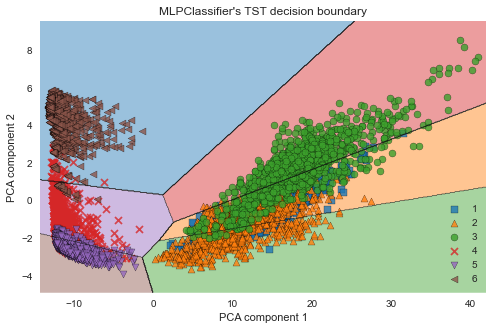

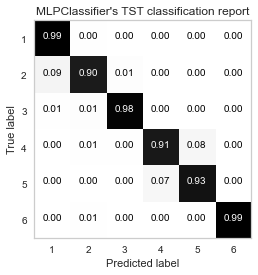

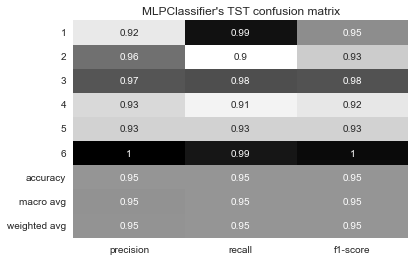

<Figure size 576x360 with 0 Axes>

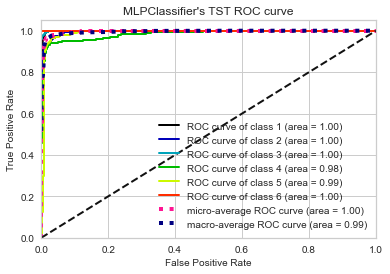

<Figure size 576x360 with 0 Axes>

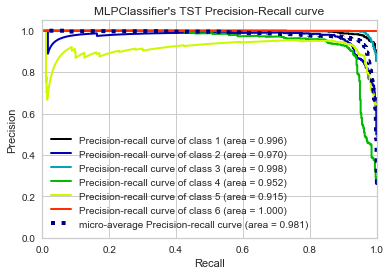

In [28]:
params_tst, tuned_model_tst, y_pred_tst, y_prob_tst, best_features, best_features_scores = \
                                                    grid_search(X_tr=X_tr, 
                                                                y_tr=y_tr,
                                                                X_ts=X_ts, 
                                                                y_ts=y_ts,
                                                                numeric_features=X_train.columns, 
                                                                categorical_features=X_train.columns, 
                                                                discretizer_flag=False,
                                                                scaler_flag=True, 
                                                                feature_filter_key="", 
                                                                feature_flag=False)


In [29]:
def plot_learning_curve(X_tr, y_tr, model, v_or_t_flag):
    second_score = ""
    if v_or_t_flag == 'VAL':
        cv = StratifiedKFold(n_splits=validation_n_splits)
        second_score = "Validation score"
    else:
        cv = StratifiedKFold(n_splits=test_n_splits)
        second_score = "Test score"
        
    my_title = model_name + "'s %s Learning Curve" % (v_or_t_flag) 
        
    sizes = np.linspace(0.3, 1.0, 10)
    plt.figure(figsize=(8, 5))
    visualizer = LearningCurve(model, cv=cv, scoring=scoring, train_sizes=sizes, 
                                                        n_jobs=-1, random_state=random_state, title=my_title)

    visualizer.fit(X_tr, y_tr.values.ravel())    
    # visualizer.ax.get_lines()[1].set_label(second_score)
    visualizer.show() 

dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'activation', 'alpha', 'batch_size', 'beta_1', 'beta_2', 'early_stopping', 'epsilon', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'max_fun', 'max_iter', 'momentum', 'n_iter_no_change', 'nesterovs_momentum', 'power_t', 'solver', 'tol', 'validation_fraction', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'activation', 'alpha', 'batch_size', 'beta_1', 'beta_2', 'early_stopping', 'epsilon', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'max_fun', 'max_iter', 'momentum', 'n_iter_no_change', 'nesterovs_momentum', 'power_t', 'solver', 'tol', 'validation_fraction', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 

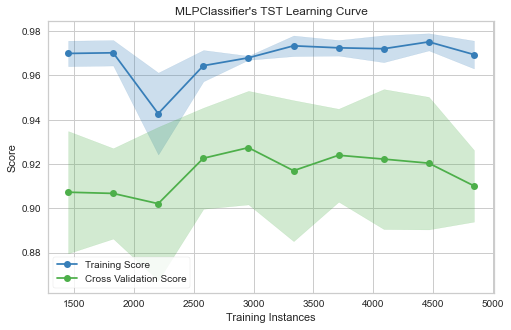

In [30]:
v_or_t_flag = "TST"
plot_learning_curve(X_train, 
                    y_train, 
                    tuned_model_tst, 
                    v_or_t_flag)

## Plot learning curve Loss and epochs

Best Config: {'preprocessor__numeric__scaler': StandardScaler(), 'model__tol': 1e-05, 'model__momentum': 0.8, 'model__learning_rate': 'constant', 'model__hidden_layer_sizes': (124, 83), 'model__early_stopping': False, 'model__alpha': 0.1, 'model__activation': 'identity'} 

In [31]:
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_norm = scaler.transform(X_tr)
X_ts_norm = scaler.transform(X_ts)

clf = tuned_model_tst
clf.fit(X_tr_norm, y_tr.values.ravel())

y_pred = clf.predict(X_ts_norm)

print('Accuracy %s' % accuracy_score(y_ts, y_pred))
print('F1-score %s' % f1_score(y_ts, y_pred, average=None))
print(classification_report(y_ts, y_pred))

Accuracy 0.9504580929759077
F1-score [0.95357834 0.93084523 0.97502973 0.91786448 0.92857143 0.99626168]
              precision    recall  f1-score   support

           1       0.92      0.99      0.95       496
           2       0.96      0.90      0.93       471
           3       0.97      0.98      0.98       420
           4       0.93      0.91      0.92       491
           5       0.93      0.93      0.93       532
           6       1.00      0.99      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



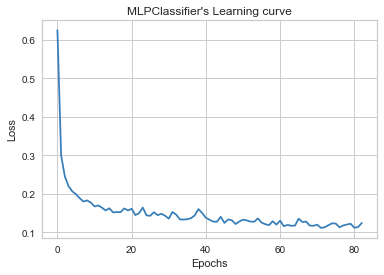

In [32]:
plt.plot(clf.loss_curve_)
plt.ylabel("Loss")
plt.xlabel("Epochs")

plt.title("MLPClassifier's Learning curve")
plt.show()

## Numero minimo di dati

In [33]:
def selezione_righe(train, activity, perc):
    df = train[train['Activity'] == activity]
    lista_righe = df[:perc].index.tolist()
    
    return lista_righe

In [34]:

riduzione = [50, 100,300,400,500,600, 700, 800, 850, 900, 950, 960, 970, 980,  1000]
for r in riduzione:
    print('--------------------------------------------')
    train_num = train.copy()
    print(train_num.shape)
    
    print('eliminate', r)

    lista_righe = selezione_righe(train_num,1,r)
    train_num.drop(lista_righe,axis=0,inplace=True)
    lista_righe = selezione_righe(train_num,2,r)
    train_num.drop(lista_righe,axis=0,inplace=True)
    lista_righe = selezione_righe(train_num,3,r)
    train_num.drop(lista_righe,axis=0,inplace=True)
    lista_righe = selezione_righe(train_num,4,r)
    train_num.drop(lista_righe,axis=0,inplace=True)
    lista_righe = selezione_righe(train_num,5,r)
    train_num.drop(lista_righe,axis=0,inplace=True)
    lista_righe = selezione_righe(train_num,6,r)
    train_num.drop(lista_righe,axis=0,inplace=True)

    print(train_num.shape)

    X_train_num = train_num.drop(['Activity'], axis=1)

    y_train_num = train_num['Activity']
    y_train_num = pd.DataFrame(y_train_num)
    print('X_train and y_train : ({},{})'.format(X_train_num.shape, y_train_num.shape))
    
    
    fitted_model = model.fit(X_train_num, y_train_num.values.ravel())
    y_pred = model.predict(X_test)
    
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))

--------------------------------------------
(7261, 201)
eliminate 50
(6961, 201)
X_train and y_train : ((6961, 200),(6961, 1))
Accuracy 0.9358669833729216
F1-score 0.9355306302310091
--------------------------------------------
(7261, 201)
eliminate 100
(6661, 201)
X_train and y_train : ((6661, 200),(6661, 1))
Accuracy 0.9256871394638616
F1-score 0.9245012674583556
--------------------------------------------
(7261, 201)
eliminate 300
(5461, 201)
X_train and y_train : ((5461, 200),(5461, 1))
Accuracy 0.9406175771971497
F1-score 0.9403200777743718
--------------------------------------------
(7261, 201)
eliminate 400
(4861, 201)
X_train and y_train : ((4861, 200),(4861, 1))
Accuracy 0.9389209365456397
F1-score 0.9384917245719281
--------------------------------------------
(7261, 201)
eliminate 500
(4261, 201)
X_train and y_train : ((4261, 200),(4261, 1))
Accuracy 0.9100780454699695
F1-score 0.9079061500170231
--------------------------------------------
(7261, 201)
eliminate 600
(3661